In [1]:
import numpy as np
import os

In [3]:
# 데이터 로드드
data = np.load('data/seq1~3000_60fps_1741667844.npy')
data.shape

### label - idx mapping정보 가져오기
import pickle
with open('data/label_to_idx.pickle', 'rb') as f:
    label_to_idx = pickle.load(f)
print(label_to_idx)

{'0': 0, '1': 1, '10': 2, '100': 3, '1000': 4, '10000': 5, '11': 6, '112': 7, '119': 8, '12': 9, '13': 10, '14': 11, '15': 12, '16': 13, '17': 14, '18': 15, '19': 16, '2': 17, '20': 18, '21': 19, '22': 20, '23': 21, '24': 22, '25': 23, '26': 24, '27': 25, '28': 26, '29': 27, '3': 28, '30': 29, '31': 30, '32': 31, '33': 32, '34': 33, '35': 34, '36': 35, '37': 36, '38': 37, '39': 38, '4': 39, '40': 40, '41': 41, '42': 42, '43': 43, '44': 44, '45': 45, '46': 46, '47': 47, '48': 48, '49': 49, '5': 50, '50': 51, '51': 52, '52': 53, '53': 54, '54': 55, '55': 56, '56': 57, '57': 58, '58': 59, '59': 60, '6': 61, '60': 62, '61': 63, '62': 64, '63': 65, '64': 66, '65': 67, '66': 68, '67': 69, '68': 70, '69': 71, '7': 72, '70': 73, '71': 74, '72': 75, '73': 76, '74': 77, '75': 78, '76': 79, '77': 80, '78': 81, '79': 82, '8': 83, '80': 84, '81': 85, '82': 86, '83': 87, '84': 88, '85': 89, '86': 90, '87': 91, '88': 92, '89': 93, '9': 94, '90': 95, '91': 96, '92': 97, '93': 98, '94': 99, '95': 100, 

In [4]:
# 라벨 값 분리
x_data = data[:,:,:-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(159020, 60, 198)
(159020,)


In [6]:

# label one hot encoding
from tensorflow.keras.utils import to_categorical
y_data = to_categorical(labels, num_classes = len(label_to_idx))
y_data.shape

(159020, 419)

In [7]:
# train test data split
from sklearn.model_selection import train_test_split
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.1, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(143118, 60, 198) (143118, 419)
(15902, 60, 198) (15902, 419)


In [8]:
# model 설정
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape = x_train.shape[1:3]), # (30,198)
    Dense(32, activation='relu'),
    Dense(len(label_to_idx), activation='softmax')
])

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


c:\Users\HyeonjiKim\anaconda3\envs\p-project\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        67,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 419)            │        13,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,235 (325.14 KB)

 Trainable params: 83,235 (325.14 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# train
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks =  [
        ModelCheckpoint('model/model.h5', monitor = 'val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor = 0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.0034 - loss: 538.1758
Epoch 1: val_acc improved from -inf to 0.00390, saving model to model/model.h5


4473/4473 ━━━━━━━━━━━━━━━━━━━━ 74s 16ms/step - acc: 0.0034 - loss: 538.0888 - val_acc: 0.0039 - val_loss: 6.0127 - learning_rate: 0.0010
Epoch 2/200
4472/4473 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.0040 - loss: 6.0080
Epoch 2: val_acc did not improve from 0.00390
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 122s 27ms/step - acc: 0.0040 - loss: 6.0080 - val_acc: 0.0039 - val_loss: 6.0108 - learning_rate: 0.0010
Epoch 3/200
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.0040 - loss: 6.0061
Epoch 3: val_acc did not improve from 0.00390
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 110s 24ms/step - acc: 0.0040 - loss: 6.0061 - val_acc: 0.0039 - val_loss: 6.0109 - learning_rate: 0.0010
Epoch 4/200
4472/4473 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.0043 - loss: 6.0060
Epoch 4: val_acc did not improve from 0.00390
4473/4473 ━━━━━━━━━━━━━━━━━━━━ 99s 22ms/step - acc: 0.0043 - loss: 6.0060 - val_acc: 0.0036 - val_loss: 6.0110 - learning_rate: 0.0010
Epoch 5/200
4471/4473 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 

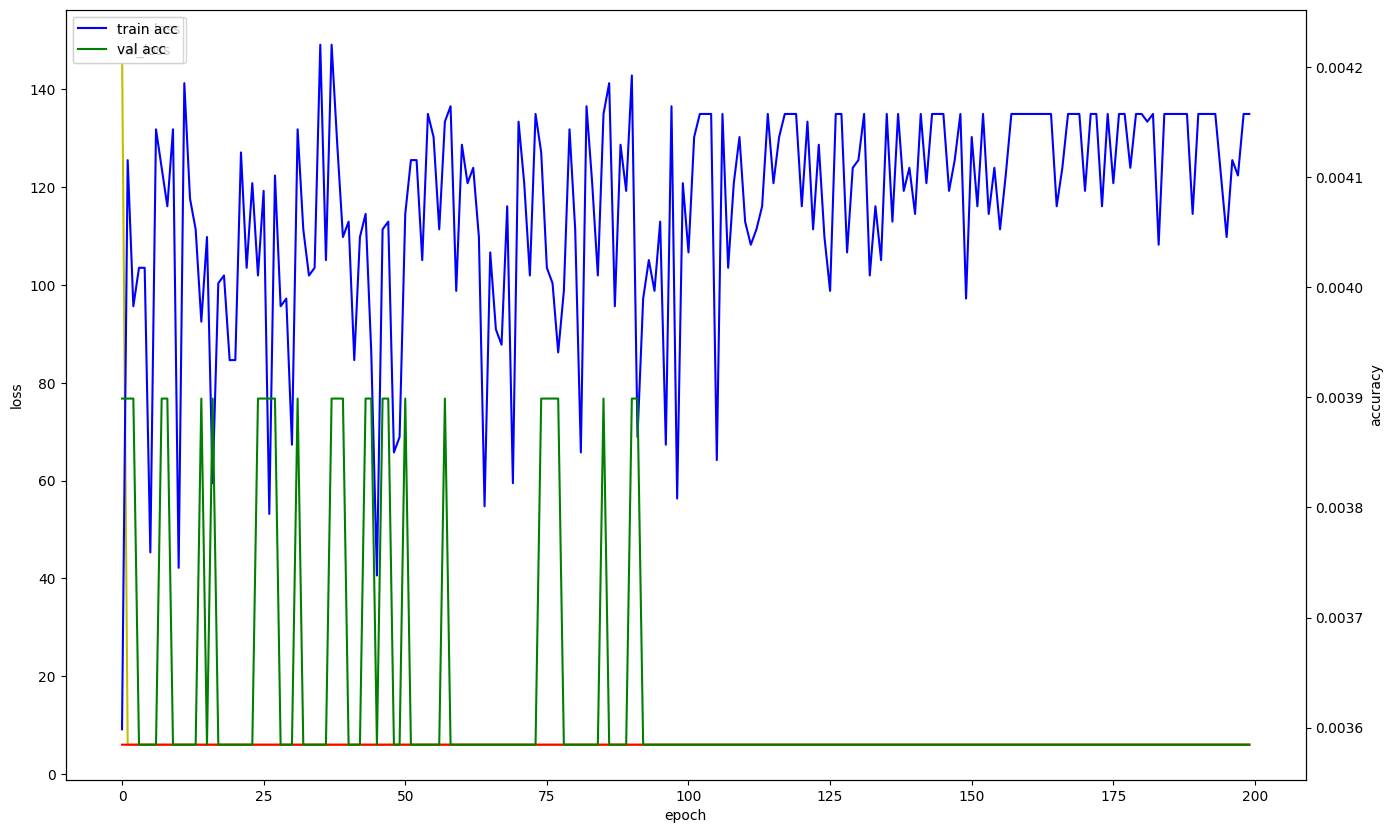

In [10]:
# acc plot
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16,10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()


In [11]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'models/model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)